In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import torchvision.models as models


In [28]:
import os
os.chdir("/kaggle/input")
os.listdir()


['AI-Realism-Subjective_Study_Data_Sheet - Combined_Ratings_Study_Pid38Dropped_Correct_ZScores_NoOutliers_Full.csv',
 'AI-Realism-Subjective_Study_Data_Sheet - Combined_Ratings_Study_Pid38Dropped_Correct_ZScores_NoOutliers.csv',
 'Dataset_images']

In [29]:
import random; import numpy as np; import torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

class ImageRatingDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
        self.augment = augment

        # Define augmentations
        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # small rotations
            transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes
        ])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'Image']
        rating = self.dataframe.loc[idx, 'Rating']

        image = Image.open("Dataset_images/"+img_path)
        if self.augment == True:
            image = self.augmentation(image)
        image_np = np.asarray(image, dtype=np.float32)
        image = torch.tensor(image_np)
        image = image.permute(2, 0, 1)
        # image = compute_mscn(image)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)


In [30]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()

        # Load pretrained ResNet18
        base_model = models.resnet18(pretrained=True)

        # Remove the final classification layer
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Excludes fc layer

        # Freeze base layers
        for param in self.features.parameters():
            param.requires_grad = False

        # Add a custom regression head
        self.regressor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)             # Output shape: (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 512)
        x = self.regressor(x)
        return x


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetRegressor().to(device)

# Replace 'your_file.xlsx' with the path to your Excel file
file_path = 'AI-Realism-Subjective_Study_Data_Sheet - Combined_Ratings_Study_Pid38Dropped_Correct_ZScores_NoOutliers_Full.csv'

# Read the Excel file into a DataFrame
df = pd.read_csv(file_path)

images = df['Image'].unique()
img_ratings  = df.groupby('Image', as_index=False)['Rating'].mean()
# print(img_ratings)

# Create bins for stratification
n_bins = 10  # You can adjust this number
img_ratings['Rating_bin'] = pd.qcut(img_ratings['Rating'], n_bins, labels=False)


# # Split into train (70%), val (15%), test (15%)
# train_df, temp_df = train_test_split(img_ratings, test_size=0.30, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
# # print(train_df, val_df, test_df)

# Stratified split
train_df, temp_df = train_test_split(img_ratings, test_size=0.30, random_state=42, stratify=img_ratings['Rating_bin'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['Rating_bin'])

# Stratified split sanity (Disjoint splits)
train_ids = set(train_df.index)
val_ids   = set(val_df.index)
test_ids  = set(test_df.index)
assert train_ids.isdisjoint(val_ids) and train_ids.isdisjoint(test_ids) and val_ids.isdisjoint(test_ids), "Overlap between splits!"


# Compute mean & std on the TRAIN set only
mos_mean = train_df['Rating'].mean()
mos_std  = train_df['Rating'].std()

# Apply z-score normalization to all three splits
for df_split in (train_df, val_df, test_df):
    df_split['Rating'] = (df_split['Rating'] - mos_mean) / mos_std


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
test_dataset = ImageRatingDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=32)


In [34]:
checkpoint_path = "/kaggle/working/resnet50_fold1.pth"    # your .pth file
state_dict = torch.load(checkpoint_path)  # or "cuda:0"
model.load_state_dict(state_dict)


/tmp/ipykernel_31/1664966796.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path)  # or "cuda:0"


<All keys matched successfully>

In [35]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Detach and move to CPU; flatten the predictions.
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)
pearson_corr, _ = pearsonr(all_labels, all_preds)

print(spearman_corr, pearson_corr)


0.654788657035848 0.7250864


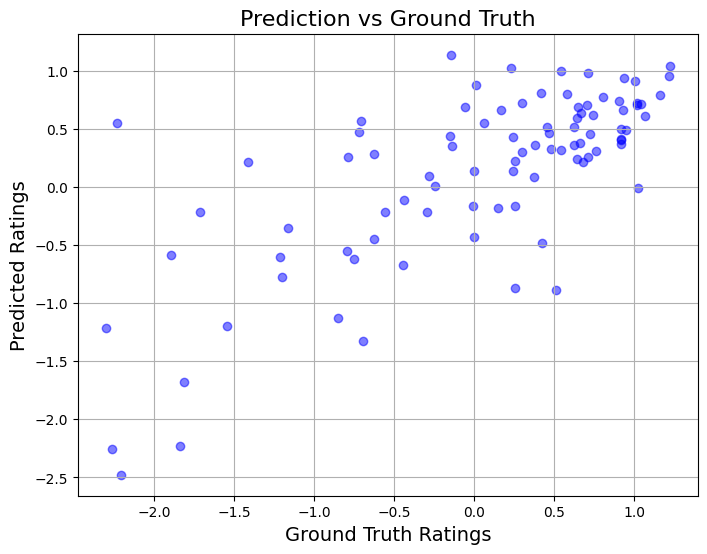

0.654788657035848 0.7250864


In [36]:
predictions = []
ground_truths = []

# Iterate over the validation dataset
with torch.no_grad():
    for images, ratings in test_loader:
        images = images.to(device)  # Move to device (GPU or CPU)
        ratings = ratings.to(device)

        # Get predictions from the model
        predicted_ratings = model(images)

        # Append predicted and ground truth values to the lists
        predictions.extend(predicted_ratings.cpu().numpy())  # move to CPU and convert to numpy
        ground_truths.extend(ratings.cpu().numpy())  # move to CPU and convert to numpy

# Convert lists to numpy arrays
predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()

# # denormalize
# predictions = predictions*mos_std + mos_mean
# ground_truths = ground_truths*mos_std + mos_mean 

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(ground_truths, predictions, alpha=0.5, c='blue')
plt.title('Prediction vs Ground Truth', fontsize=16)
plt.xlabel('Ground Truth Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid(True)
plt.show()

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)

print(spearman_corr, pearson_corr)
